# XGBoost Classifier

Este notebook implementa un modelo de **XGBoost** (eXtreme Gradient Boosting) para la Parte III del TP.

Se busca cumplir con:
- F1 Score > 0.8 en validación.
- Feature Engineering específico (Mean Encoding + One Hot Encoding).
- Búsqueda de hiperparámetros.

## Imports

In [ ]:
# Standard
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

# ML Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

# NLP
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.cli import download

# Configuración de Spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

## Constantes

In [2]:
COLOR_NO_DISASTER = '#3498db'
COLOR_DISASTER = '#e74c3c'
COLOR_GENERAL = '#95a5a6'

SEED = 42
np.random.seed(SEED)

## Datos

In [3]:
data_path = pathlib.Path("../.data/raw")
df = pd.read_csv(data_path / "train.csv")
test_df = pd.read_csv(data_path / "test.csv")

print(f'Shape Train: {df.shape}')
print(f'Shape Test: {test_df.shape}')

Shape Train: (7613, 5)
Shape Test: (3263, 4)


## Feature Engineering

Pipeline consistente con el resto de modelos:
1. **Mean Encoding**: Sobre la columna `keyword`.
2. **One Hot Encoding**: Sobre los top 20 `keyword`.
3. **TF-IDF + SVD**: Para el texto.

In [4]:
def extract_features(df):
    df = df.copy()
    
    # Texto limpio y lematizado
    df['clean_text'] = df['text'].str.lower().apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    
    # Features estadísticas numéricas
    df['word_count'] = df['text'].str.split().str.len()
    df['char_count'] = df['text'].str.len()
    df['stopwords_count'] = df['text'].str.lower().str.split().apply(lambda x: sum(w in STOP_WORDS for w in x))
    df['hashtag_count'] = df['text'].str.count(r'#\w+')
    df['mention_count'] = df['text'].str.count(r'@\w+')
    df['url_count'] = df['text'].str.count(r'http\S+|www\S+')
    df['punct_count'] = df['text'].str.count(r'[^\w\s]')
    
    # Valid Location (para OHE más tarde)
    df['has_location'] = df['location'].notna().astype(int)
    
    # Keywords limpieza
    df['keyword'] = df['keyword'].fillna('unknown')
    df['keyword_lemma'] = df['keyword'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(str(x))]))
    
    return df

print("Extrayendo features...")
df = extract_features(df)
test_df = extract_features(test_df)

Extrayendo features...


In [ ]:
# 1. TF-IDF + SVD (Dense Text Features)
print("Generando features de texto densas (SVD)...")
text_pipeline = Pipeline([
    ('union', FeatureUnion([
        ('word', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)),
        ('char', TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=3000, min_df=2)),
    ])),
    ('svd', TruncatedSVD(n_components=300, random_state=SEED))
])

# Fit transform en train, transform en test
X_text_train = text_pipeline.fit_transform(df['clean_text'])
X_text_test = text_pipeline.transform(test_df['clean_text'])

# 2. Features Numéricas (sin escalado - XGBoost no lo necesita)
num_cols = ['word_count', 'char_count', 'stopwords_count', 'hashtag_count', 'mention_count', 'url_count', 'punct_count']
X_num_train = df[num_cols].values
X_num_test = test_df[num_cols].values

# 3. One Hot Encoding (Top 20 keywords)
top_keywords = df['keyword'].value_counts().index[:20]
df['keyword_top'] = df['keyword'].apply(lambda x: x if x in top_keywords else 'other')
test_df['keyword_top'] = test_df['keyword'].apply(lambda x: x if x in top_keywords else 'other')

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_ohe_train = ohe.fit_transform(df[['keyword_top', 'has_location']])
X_ohe_test = ohe.transform(test_df[['keyword_top', 'has_location']])

print(f"Text SVD Shape: {X_text_train.shape}")
print(f"Numeric Shape: {X_num_train.shape}")
print(f"OHE Shape: {X_ohe_train.shape}")

Generando features de texto densas (SVD)...
Text SVD Shape: (7613, 300)
Numeric Scaled Shape: (7613, 7)
OHE Shape: (7613, 23)


## Split y Mean Encoding
Aplicamos **Mean Encoding** dentro del split para evitar Data Leakage.

In [6]:
y = df['target'].values

# Indices para split
indices = np.arange(len(df))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=SEED, stratify=y)

# Mean Encoding
train_df_split = df.iloc[train_idx]
val_df_split = df.iloc[val_idx]

global_mean = train_df_split['target'].mean()
keyword_means = train_df_split.groupby('keyword_lemma')['target'].mean()

X_me_train = train_df_split['keyword_lemma'].map(keyword_means).fillna(global_mean).values.reshape(-1, 1)
X_me_val = val_df_split['keyword_lemma'].map(keyword_means).fillna(global_mean).values.reshape(-1, 1)
X_me_test_submission = test_df['keyword_lemma'].map(keyword_means).fillna(global_mean).values.reshape(-1, 1)

# Concatenar todas las features
# Train Split
X_train = np.hstack([X_text_train[train_idx], X_num_train[train_idx], X_ohe_train[train_idx], X_me_train])
y_train = y[train_idx]

# Validation Split
X_val = np.hstack([X_text_train[val_idx], X_num_train[val_idx], X_ohe_train[val_idx], X_me_val])
y_val = y[val_idx]

# Submission Test (Full)
X_test_sub = np.hstack([X_text_test, X_num_test, X_ohe_test, X_me_test_submission])

print(f"Final Training Matrix Shape: {X_train.shape}")

Final Training Matrix Shape: (6090, 331)


## Entrenamiento del Modelo

Utilizamos `XGBClassifier` con `RandomizedSearchCV`.

In [7]:
xgb = XGBClassifier(random_state=SEED, eval_metric='logloss')

param_distributions = {
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions, 
    n_iter=20,
    cv=skf, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1,
    random_state=SEED
)

print("Entrenando XGBoost...")
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

print(f'Mejores parámetros: {random_search.best_params_}')
print(f'Mejor F1-Score (CV Interno): {random_search.best_score_:.4f}')

Entrenando XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.9, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Mejor F1-Score (CV Interno): 0.7525


## Análisis Final

Validamos contra el set de validación externo y graficamos los resultados.

Best Threshold: 0.420
Best F1 Score (Validation): 0.7698


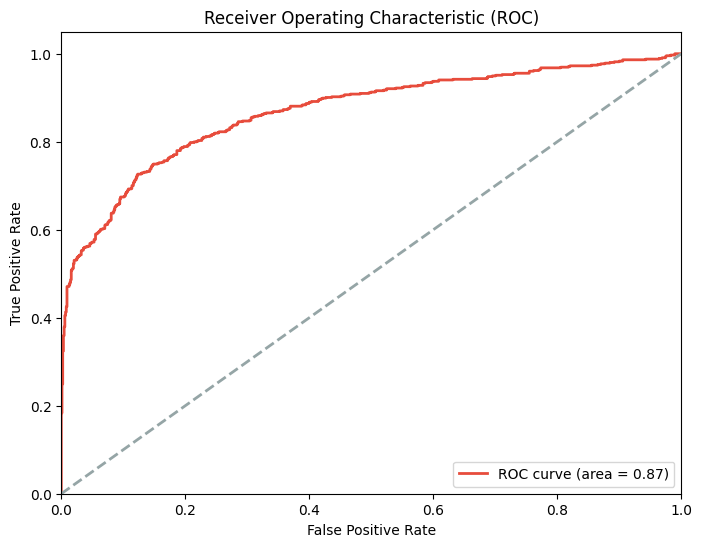

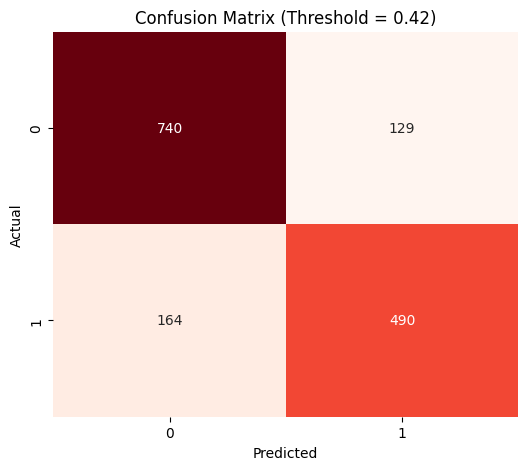

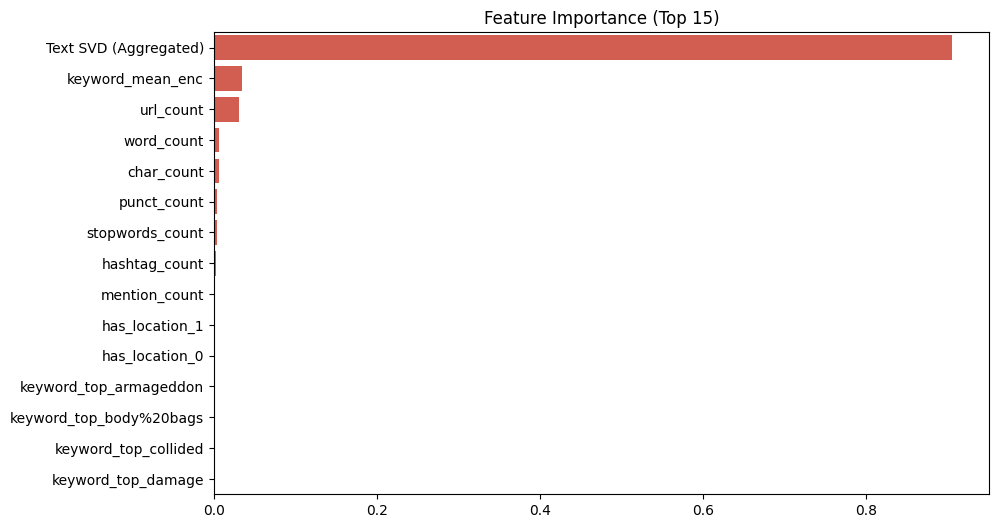

In [8]:
# Predicciones
y_val_probs = best_model.predict_proba(X_val)[:, 1]

# 1. Optimización de Threshold
best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (y_val_probs > thresh).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"Best Threshold: {best_thresh:.3f}")
print(f"Best F1 Score (Validation): {best_f1:.4f}")

# 2. Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLOR_DISASTER, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=COLOR_GENERAL, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 3. Matriz de Confusión
y_val_pred = (y_val_probs > best_thresh).astype(int)
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Feature Importance
# Nombres de features aproximados
feature_groups = ['Text SVD'] * 300 + num_cols + list(ohe.get_feature_names_out()) + ['keyword_mean_enc']
importances = best_model.feature_importances_

# Agrupamos importancias
imp_dict = {}
for name, imp in zip(feature_groups, importances):
    if 'Text SVD' in name:
        imp_dict['Text SVD (Aggregated)'] = imp_dict.get('Text SVD (Aggregated)', 0) + imp
    else:
        imp_dict[name] = imp

sorted_feats = sorted(imp_dict.items(), key=lambda x: x[1], reverse=True)
f_names = [x[0] for x in sorted_feats[:15]]
f_vals = [x[1] for x in sorted_feats[:15]]

plt.figure(figsize=(10, 6))
sns.barplot(x=f_vals, y=f_names, color=COLOR_DISASTER)
plt.title("Feature Importance (Top 15)")
plt.show()

## Submission

In [9]:
# Predecir Test
y_test_probs = best_model.predict_proba(X_test_sub)[:, 1]
y_test_pred = (y_test_probs > best_thresh).astype(int)

submission = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred})

submission_path = pathlib.Path("../.data/submission")
submission_path.mkdir(parents=True, exist_ok=True)
submission.to_csv(submission_path / "xgboost_submission.csv", index=False)

print(f"Submission guardada en {submission_path / 'xgboost_submission.csv'}")

Submission guardada en ..\.data\submission\xgboost_submission.csv
